IMPORT LIBRARY

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [11]:
image_height = 224
image_width = 224
batch_size = 16


In [12]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    r"E:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Tugas Pratikum Neural Network\animal_data",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=12,
    validation_split=0.1,
    subset="training"
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    r"E:\ADSA\KULIAH\SEMESTER 4\KECERDASAN BUATAN\Tugas Pratikum Neural Network\animal_data",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=12,
    validation_split=0.1,
    subset="validation"
)


Found 1944 files belonging to 15 classes.
Using 1750 files for training.
Found 1944 files belonging to 15 classes.
Using 194 files for validation.


In [13]:
def normalize_img(image, label):
    normalized_image = tf.cast(image, tf.float32) / 255.0
    return normalized_image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache().prefetch(AUTOTUNE)
ds_validation = ds_validation.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_validation = ds_validation.cache().prefetch(AUTOTUNE)


In [14]:
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, 3, padding="same", name="conv1", kernel_regularizer=keras.regularizers.l2(.01)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, 3, padding="same", name="conv2", kernel_regularizer=keras.regularizers.l2(.01)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(15, name="output_layer")
])


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │     6,021,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,079,055 (68.97 MB)

 Trainable params: 6,026,319 (22.99 MB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 12,052,640 (45.98 MB)

In [15]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=.0001),
    metrics=["accuracy"]
)


In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

In [19]:
history = model.fit(ds_train, epochs=20, validation_data=ds_validation, callbacks=callbacks, verbose=2)

Epoch 1/20
110/110 - 89s - 811ms/step - accuracy: 0.2629 - loss: 7.1804 - val_accuracy: 0.1289 - val_loss: 3.3130 - learning_rate: 1.0000e-04
Epoch 2/20
110/110 - 80s - 730ms/step - accuracy: 0.5680 - loss: 3.0907 - val_accuracy: 0.1856 - val_loss: 4.2087 - learning_rate: 1.0000e-04
Epoch 3/20
110/110 - 80s - 725ms/step - accuracy: 0.6926 - loss: 1.8731 - val_accuracy: 0.2784 - val_loss: 4.1243 - learning_rate: 1.0000e-04
Epoch 4/20
110/110 - 83s - 752ms/step - accuracy: 0.7829 - loss: 1.3588 - val_accuracy: 0.4381 - val_loss: 3.9826 - learning_rate: 1.0000e-04
Epoch 5/20
110/110 - 84s - 764ms/step - accuracy: 0.9154 - loss: 0.5800 - val_accuracy: 0.5876 - val_loss: 2.2059 - learning_rate: 2.0000e-05
Epoch 6/20
110/110 - 85s - 774ms/step - accuracy: 0.9554 - loss: 0.4462 - val_accuracy: 0.6701 - val_loss: 2.0050 - learning_rate: 2.0000e-05
Epoch 7/20
110/110 - 82s - 747ms/step - accuracy: 0.9674 - loss: 0.4151 - val_accuracy: 0.6907 - val_loss: 2.0141 - learning_rate: 2.0000e-05
Epoch 

In [20]:
loss, accuracy = model.evaluate(ds_validation)
print(f"Validation Accuracy: {accuracy:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6843 - loss: 2.2249
Validation Accuracy: 0.7062


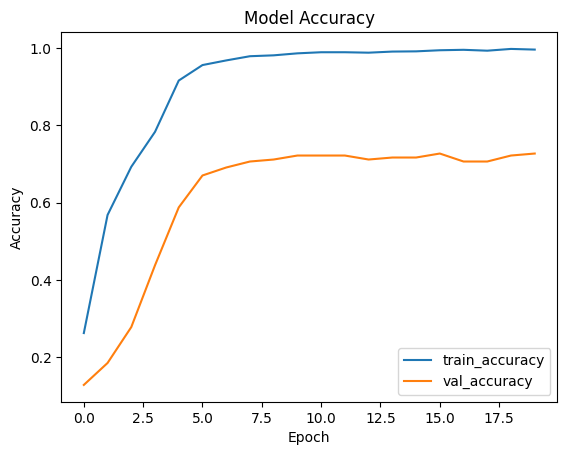

In [21]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: Dog


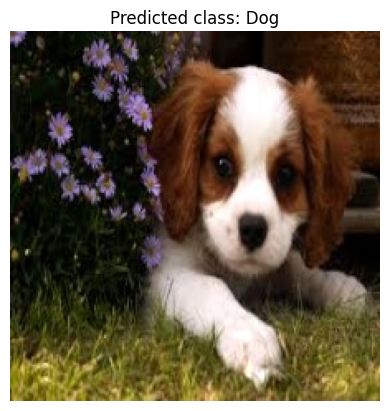

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to a sample image
img_path = 'E:/ADSA/KULIAH/SEMESTER 4/KECERDASAN BUATAN/Tugas Pratikum Neural Network/animal_data/Dog/Dog_1_2.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Define a mapping from class indices to class names
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse',  'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

# Get the predicted class name
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: Dog


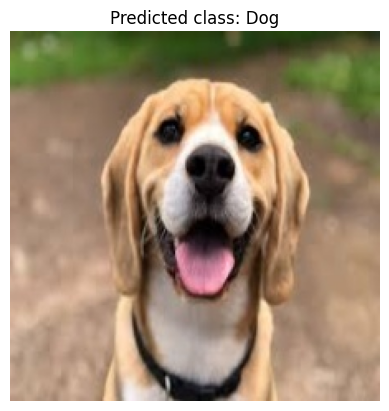

In [26]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to a sample image
img_path = 'E:/ADSA/KULIAH/SEMESTER 4/KECERDASAN BUATAN/Tugas Pratikum Neural Network/animal_data/Dog/Dog_2_1.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Define a mapping from class indices to class names
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse',  'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

# Get the predicted class name
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: Dolphin


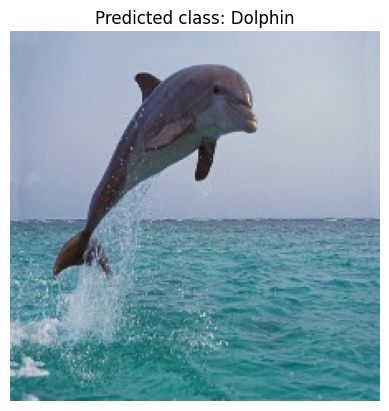

In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to a sample image
img_path = 'E:/ADSA/KULIAH/SEMESTER 4/KECERDASAN BUATAN/Tugas Pratikum Neural Network/animal_data/Dolphin/Dolphin_2_1.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Define a mapping from class indices to class names
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse',  'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

# Get the predicted class name
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: Cat


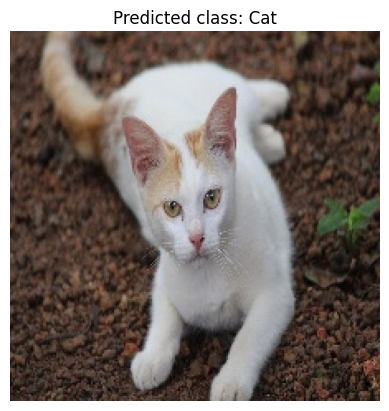

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to a sample image
img_path = 'E:/ADSA/KULIAH/SEMESTER 4/KECERDASAN BUATAN/Tugas Pratikum Neural Network/animal_data/Cat/Cat_2_1.jpg'
img_path = 'E:/ADSA/KULIAH/SEMESTER 4/KECERDASAN BUATAN/Tugas Pratikum Neural Network/animal_data/Cat/Cat_3_1.jpg'
img_path = 'E:/ADSA/KULIAH/SEMESTER 4/KECERDASAN BUATAN/Tugas Pratikum Neural Network/animal_data/Cat/Cat_4_1.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Define a mapping from class indices to class names
class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse',  'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

# Get the predicted class name
predicted_class_name = class_names[predicted_class[0]]

# Print the predicted class
print(f"Predicted class: {predicted_class_name}")

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted class: {predicted_class_name}")
plt.axis('off')
plt.show()
